# A simple matrix product state (MPS) emulator

In this notebook, we show a very simple implementation of a circuit emulator using a MPS representation of the quantum state.

We use a ``MPSState`` class to store the state in MPS form, namely to store the tensors of the MPS:
$$\psi_{b_1, \dots, b_n} = \mathrm{Tr} \left[ (A^{(1)})^{b_1} \dots (A^{(n)})^{b_n}\right]$$

with $A^{(i)}$ a $\chi \times 2 \times \chi$ tensor: $$(A^{(i)})^{b_i}_{k_i, k_{i+1}}$$ with $b_i = 0, 1$ and $k_i = 0\dots \chi-1$.

We recall that applying a single qubit gate $U$ to qubit $i$ corresponds to contracting the gate $U$ to tensor $A^{(i)}$:
$$(\tilde{A}^{(i)})^{b}_{k, k'}= \sum_{b'} U_{b, b'} (A^{(i)})^{b'}_{k, k'}.$$
The two-qubit case is detailed in the exercise sheet.

The main numpy function that you will need is the ``numpy.tensordot`` method. It allow to contract two tensors $A$ and $B$. If the ``axes`` parameter is not set, then, supposing we start from $A_{i, j, k}$ and $B_{l, m, n, p}$, the contraction is done on the last and first index of $A$ and $B$, respectively:

$$C_{i, j, m, n, p} = \sum_k A_{i, j, k} B_{k, m, n, p}.$$

One can also specify which indices to sum over. For instance, if ``axes = [(0, 2), (1, 2)]``,

$$C_{i, l, p} = \sum_{k, m} A_{k, i, m} B_{l, k, m, p}.$$

The ``numpy.transpose`` method will also be useful to reorder indices.

## A skeleton class

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from tools import Circuit, gate_dic

class MPSState:
    """class containing the MPS representation of a quantum state
    
    the MPS is stored as a list of tensors.
    
    Attributes:
        nqbits (int): number of qubits
        tensors (list<np.array>): list of tensors
        bond_dim (int): bond dimension
        
    Args:
        nqbits (int): the number of qubits
        bond_dim (int): the (maximal) bond dimension (chi)
    """
    
    def __init__(self, nqbits, bond_dim=2):
        """initialize the MPS to |0, 0, ...0>
        
        Args:
            nqbits (int): the number of qubits
            bond_dim (int): the (maximal) bond dimension (chi)
        """
        self.nqbits = nqbits
        self.tensors = [np.zeros((1, 2, 1), np.complex128) for _ in range(nqbits)] # be carerul fo the convetion for the order (note that we have 1 when no entanglement)
        # state |0, 0, ..., 0>
        for qb in range(nqbits):
            self.tensors[qb] = [[[1], [0]]]
            # self.tensors[qb][0,0,0] = 1.0 # only component required to be 1 ! 
        self.bond_dim = bond_dim
        
    def apply(self, gate, qbits, param=None):
        """
        Apply a gate to the current state.
        
        Args:
            gate (string): name of gate
            qbits (list<int>): qubits on which it acts
            param (float, optional): parameter of gate (if applicable)
        
        """
        # ...
        if len(qbits) > 2: raise Exception(f"The gate acts on too many ({len(qbits)}) qubits")
        gate_ = gate_dic[gate] if param is None else gate_dic[gate](param)
        # gate_ is a (2, 2) or (4,4) array
        
        if len(qbits) == 1:
            # apply the gate
            # Hint: use tensordot function
            tmp = np.tensordot(gate_, self.tensors[qbits[0]], axes=[1,1])
            # Do not forget to reorder the indices after the tensordot ! 
            tmp = np.transpose(tmp, (1,0,2))
            self.tensors[qbits[0]] = tmp
        else:
            # put qubits in right order
            if qbits[0] < qbits[1]:
                q1, q2 = qbits[0], qbits[1] 
            else:
                q1, q2 = qbits[1], qbits[0]
                gate_ = np.reshape(gate_, (2, 2, 2, 2))
                # swap q1 and q2
                gate_ = np.transpose(gate_, (1, 0, 3, 2))
                gate_ = np.reshape(gate_, (4, 4))
                
            if q1 != q2 - 1: 
                raise Exception("the gate must be applied on neighboring qubits")
                
            # merge the two neighboring tensors
            # Hint: tensordot
            T = np.tensordot(self.tensors[q1], self.tensors[q2], axes= [-1,0])
            T = np.reshape(T, (T.shape[0], 4, T.shape[3])) 
            
            # apply the gate -> it has already the right shape ! (4: out index, 4:in index)
            # Hint: tensordot
            T = np.tensordot(T, gate_, axes=[1, 1])
            # and now I have to be careful to the order of the indices 
            T = np.transpose(T, (0,2,1))
            T = np.reshape(T, (T.shape[0], 2, 2, T.shape[2]))
            
            # now compress by SVD
            T = np.reshape(T, (T.shape[0]*T.shape[1], T.shape[2]*T.shape[3]))
            u, s, vh = np.linalg.svd(T, full_matrices=False)
            # truncate to bond dimension and discard unnecessary columns/rows for u and vh
            chi_eff = min(self.bond_dim, u.shape[1])
            u = u[:, :chi_eff]
            s = s[:chi_eff]
            vh = vh[:chi_eff, :]
            
            # renormalize so that sum s^2 = 1
            s = s/np.linalg.norm(s)
            
            self.tensors[q1] = np.reshape(u, (u.shape[0]//2, 2, u.shape[1]))
            self.tensors[q2] = np.diag(s)@vh
            self.tensors[q2] = np.reshape(self.tensors[q2], (self.tensors[q2].shape[0], 2, self.tensors[q2].shape[1]//2))
            
        
    def __str__(self):
        string = ""
        for qb in range(self.nqbits):
            string += str(self.tensors[qb].shape) + "\n"
        return string
        
        
    def to_vec(self):
        """contract MPS to dense vector"""
        result = self.tensors[0]
        for qb in range(1, self.nqbits):
            result = np.tensordot(result, self.tensors[qb], axes=[-1, 0])
        result = np.reshape(result, (2**self.nqbits,))
        return result 


### A few tests

In [22]:
# a couple of tests
psi = MPSState(2)
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 0, 0]))<1e-13)

psi.apply("H", [0])
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 1, 0])/np.sqrt(2))<1e-13)

psi.apply("CNOT", [0, 1])
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 0, 1])/np.sqrt(2))<1e-13)

psi.apply("CNOT", [0, 1])
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 1, 0])/np.sqrt(2))<1e-13)

psi.apply("CNOT", [1, 0])
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 1, 0])/np.sqrt(2))<1e-13)

psi.apply("RY", [1], np.pi/2)
assert(np.linalg.norm(psi.to_vec() - np.array([1, 1, 1, 1])/2)<1e-13)

## An emulator (QPU) based on a MPS representation.

In [9]:
class MPSQPU:
    "Simulator based on MPS"
    def __init__(self, nqbits, bond_dim=2):
        self.state = MPSState(nqbits, bond_dim)
        
    def submit(self, circuit):
        """
        Args:
            circuit (Circuit): a quantum circuit to be simulated
        """
        assert(circuit.nqbits == self.state.nqbits)
        for gate_tuple in circuit.gates:
            self.state.apply(*gate_tuple)
            
        return self.state



In [23]:
# test with a circuit
circ = Circuit(2, [("H", [0]), ("CNOT", [0, 1])])

qpu = MPSQPU(2)
res = qpu.submit(circ)

print(res.to_vec()) # what do you expect?

[0.70710678 0.         0.         0.70710678]


## With random circuits

Here we create a function that returns a random circuit, and compare the execution of this circuit on a perfect emulator (``StateVectorQPU``) and our MPS emulator.

Singular values at middle bond: [1.00000000e+00 1.36773361e-15 1.18550324e-15 ... 3.09203351e-17
 2.72388429e-17 9.72701940e-18]
Number of non-zero singular values: 1
2 1.0000000000000062
Singular values at middle bond: [1.00000000e+00 1.36773361e-15 1.18550324e-15 ... 3.09203351e-17
 2.72388429e-17 9.72701940e-18]
Number of non-zero singular values: 1
4 1.0000000000000062
Singular values at middle bond: [1.00000000e+00 1.36773361e-15 1.18550324e-15 ... 3.09203351e-17
 2.72388429e-17 9.72701940e-18]
Number of non-zero singular values: 1
8 1.0000000000000062
Singular values at middle bond: [1.00000000e+00 1.36773361e-15 1.18550324e-15 ... 3.09203351e-17
 2.72388429e-17 9.72701940e-18]
Number of non-zero singular values: 1
16 1.0000000000000062
Singular values at middle bond: [1.00000000e+00 1.36773361e-15 1.18550324e-15 ... 3.09203351e-17
 2.72388429e-17 9.72701940e-18]
Number of non-zero singular values: 1
32 1.0000000000000062
Singular values at middle bond: [1.00000000e+00 1.36773361

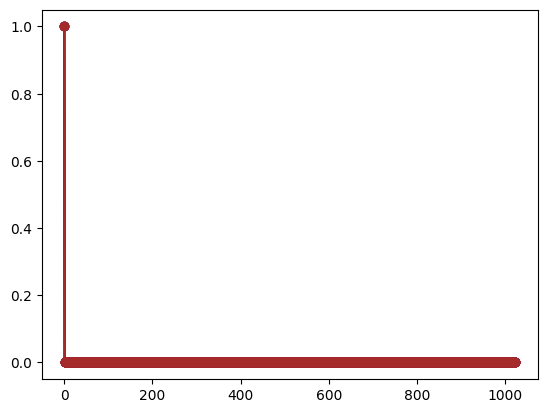

In [36]:
from state_vector_qpu import StateVectorQPU # a Schrödinger-style dense representation simulator
nqbits = 20

def random_circuit(nqbits, nlayers):
    # function to create a random circuits on nqbits with nlayers
    gates = []
    for i in range(nlayers): 
        for k in range(nqbits):
            rd = np.random.rand(3)
            gates.append(("RX", [k], rd[0]*np.pi))
            gates.append(("RY", [k], rd[1]*np.pi))
            gates.append(("RZ", [k], rd[2]*np.pi))

        if i % 2 == 0:
            for k in range(0, nqbits-1, 2):
                gates.append(("CNOT", [k, k+1]))
        
    return Circuit(nqbits, gates)
            


circ = random_circuit(nqbits, 20)
qpu = StateVectorQPU(nqbits, gate_dic)
res = qpu.submit(circ)

bond_dim_list = [2, 4, 8, 16, 32, 64]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

fid_list = []
for bond_dim in bond_dim_list:
    qpu = MPSQPU(nqbits, bond_dim=bond_dim)
    res_mps = qpu.submit(circ)

    # Get the middle bond (between qubits nqbits//2 - 1 and nqbits//2)
    middle = nqbits // 2

    # Contract tensors from the left (qubits 0 to middle-1)
    left = res_mps.tensors[0]
    for i in range(1, middle):
        left = np.tensordot(left, res_mps.tensors[i], axes=[-1, 0])
    # Reshape: left has shape (..., 2, 2, ..., 2, chi)
    left = np.reshape(left, (2**middle, left.shape[-1]))

    # Contract tensors from the right (qubits middle to nqbits-1)
    right = res_mps.tensors[middle]
    for i in range(middle + 1, nqbits):
        right = np.tensordot(right, res_mps.tensors[i], axes=[-1, 0])
    # Reshape: right has shape (chi, 2, 2, ..., 2)
    right = np.reshape(right, (right.shape[0], 2**(nqbits - middle)))

    # Combine and perform SVD
    combined = left @ right
    _, s, _ = np.linalg.svd(combined, full_matrices=False)

    # s now contains the singular values (Schmidt coefficients) of the middle bond
    print(f"Singular values at middle bond: {s}")
    print(f"Number of non-zero singular values: {np.sum(s > 1e-10)}")

    plt.plot(np.arange(len(s)), s, marker='o', label=f'Bond dim {bond_dim}', color = colors[bond_dim_list.index(bond_dim)])

    # compute fidelity |<psi|psi_MPS>|^2
    fid = np.abs(np.vdot(res.to_vec(), res_mps.to_vec()))**2
    print(bond_dim, fid)
    fid_list.append(fid)
    
# plt.plot(bond_dim_list, fid_list, '-o', lw=3)
# plt.xlabel("Bond dimension")
# plt.ylabel("Fidelity")
# plt.grid()

## Going further

- compute the run time as a function of the bond dimension
- implement the measurement of an observable $H$ decomposed on the Pauli basis, $H = \sum_i \lambda_i P_i$.
- implement the canonicalization of the MPS
- run the emulator on circuits with 100 qubits!